## Supervised Example (Neural Network Logistic Regression)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import six
import tensorflow as tf

from edward.models import Normal, Bernoulli
from edward.stats import norm, bernoulli
from edward.util import rbf

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['ggplot', 'seaborn-white'])
import itertools

import scipy
from scipy.stats import gaussian_kde

In [2]:
ed.set_seed(42)

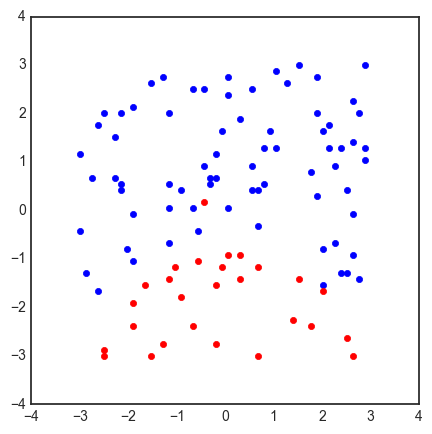

In [3]:
N = 100
D = 2

px1 = np.linspace(-3, 3, 50)
px2 = np.linspace(-3, 3, 50)

px1_m, px2_m = np.mgrid[-3:3:50j, -3:3:50j]

xeval = np.vstack((px1_m.flatten(), px2_m.flatten())).T
x_viz = tf.constant(np.array(xeval, dtype='float32'))

def build_toy_dataset(N):
  x = xeval[np.random.randint(xeval.shape[0],size=N),:]
  y = bernoulli.rvs( p=scipy.stats.logistic.cdf( 5*x[:,0]**2 + 5*x[:,1]**3 ) ) 
  return x, y

x_train, y_train = build_toy_dataset(N,)

fig = plt.figure(figsize=(5 ,5))
ax = plt.subplot()

ax.scatter(x_train[(y_train==1)[0], 0], x_train[(y_train==1)[0],  1], color='b')
ax.scatter(x_train[(y_train==0)[0], 0], x_train[(y_train==0)[0],  1], color='r')

gif = plt.show()

### Load Crabs Dataset

In [3]:
# N = 100
# D = 5
# df = np.loadtxt('crabs_train.txt', dtype='float32', delimiter=',')
# x_train = df[:, 1:]

# # subtract mean of each column
# x_col_offset = np.mean(x_train, axis=0)
# x_train = x_train - x_col_offset

# y_train = df[:, 0].astype(int)
# y_train[y_train==-1] = 0
# y_train = np.atleast_2d(y_train)

In [4]:
# N = 178
# D = 13
# df = np.loadtxt('wine.data.txt', dtype='float32', delimiter=',')
# x_train = df[:, 1:]

# # subtract mean of each column
# x_col_offset = np.mean(x_train, axis=0)
# x_train = x_train - x_col_offset

# y_train = df[:, 0].astype(int)
# y_train[y_train==2] = 0
# y_train[y_train==3] = 0
# y_train = np.atleast_2d(y_train)

In [77]:
N = 200
D = 2
x_train = np.loadtxt('x.csv', dtype='float32', delimiter=',')
y_train = np.loadtxt('y.csv', dtype='int', delimiter=',')
y_train = np.atleast_2d(y_train)

### Plots (just to get a feel for dataset)

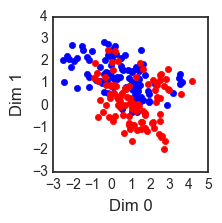

In [78]:
fig = plt.figure(figsize=(2,2))
ax = plt.subplot()

ax.scatter(x_train[(y_train==1)[0], 0], x_train[(y_train==1)[0],  1], color='b')
ax.scatter(x_train[(y_train==0)[0], 0], x_train[(y_train==0)[0],  1], color='r')

ax.set_xlabel('Dim '+str(0))
ax.set_ylabel('Dim '+str(1))

gif = plt.plot 

In [9]:
# for out_dim in range(D):
#     for dim in [0]:
#         fig = plt.figure(figsize=(2,2))
#         ax = plt.subplot()

#         ax.scatter(x_train[(y_train==1)[0], out_dim], x_train[(y_train==1)[0],  dim], color='b')
#         ax.scatter(x_train[(y_train==0)[0], out_dim], x_train[(y_train==0)[0],  dim], color='r')

#         ax.set_xlabel('Dim '+str(out_dim))
#         ax.set_ylabel('Dim '+str(dim))

#         gif = plt.plot 

### Define Neural Network Logistic Model

In [68]:
# def neural_network(x, W_0, W_1, b_0, b_1):
#     h = tf.nn.tanh(tf.matmul(x, W_0) + b_0)
#     h = tf.matmul(h, W_1) + b_1
#     return tf.reshape(h, [-1])

# L = 50

# W_0 = Normal(mu=tf.zeros([D, L]), sigma=tf.ones([D, L]))
# W_1 = Normal(mu=tf.zeros([L, 1]), sigma=tf.ones([L, 1]))
# b_0 = Normal(mu=tf.zeros(L), sigma=tf.ones(L))
# b_1 = Normal(mu=tf.zeros(1), sigma=tf.ones(1))

# x = tf.convert_to_tensor(x_train, dtype=tf.float32)
# y = Bernoulli(logits=neural_network(x, W_0, W_1, b_0, b_1))

### Define Variational Approximation Distributions

In [69]:
# qW_0 = Normal(mu=tf.Variable(tf.random_normal([D, L])),
#               sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D, L]))))
# qW_1 = Normal(mu=tf.Variable(tf.random_normal([L, 1])),
#               sigma=tf.nn.softplus(tf.Variable(tf.random_normal([L, 1]))))
# qb_0 = Normal(mu=tf.Variable(tf.random_normal([L])),
#               sigma=tf.nn.softplus(tf.Variable(tf.random_normal([L]))))
# qb_1 = Normal(mu=tf.Variable(tf.random_normal([1])),
#               sigma=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

# data = {y: y_train}
# inference = ed.MFVI({W_0: qW_0, b_0: qb_0,
#                      W_1: qW_1, b_1: qb_1}, data)

### Define Neural Network Logistic Model

In [35]:
def neural_network(x, W_0, W_1, W_2, b_0, b_1, b_2):
    h = tf.nn.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.nn.tanh(tf.matmul(h, W_1) + b_1)
    h = tf.matmul(h, W_2) + b_2
    return tf.reshape(h, [-1])

L = 2

W_0 = Normal(mu=tf.zeros([D, L]), sigma=tf.ones([D, L]))
W_1 = Normal(mu=tf.zeros([L, L]), sigma=tf.ones([L, L]))
W_2 = Normal(mu=tf.zeros([L, 1]), sigma=tf.ones([L, 1]))
b_0 = Normal(mu=tf.zeros(L), sigma=tf.ones(L))
b_1 = Normal(mu=tf.zeros(L), sigma=tf.ones(L))
b_2 = Normal(mu=tf.zeros(1), sigma=tf.ones(1))

x = tf.convert_to_tensor(x_train, dtype=tf.float32)
y = Bernoulli(logits=neural_network(x, W_0, W_1, W_2, b_0, b_1, b_2))

### Define Variational Approximation Distributions

In [36]:
qW_0 = Normal(mu=tf.Variable(tf.random_normal([D, L])),
              sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D, L]))))
qW_1 = Normal(mu=tf.Variable(tf.random_normal([L, L])),
              sigma=tf.nn.softplus(tf.Variable(tf.random_normal([L, L]))))
qW_2 = Normal(mu=tf.Variable(tf.random_normal([L, 1])),
              sigma=tf.nn.softplus(tf.Variable(tf.random_normal([L, 1]))))
qb_0 = Normal(mu=tf.Variable(tf.random_normal([L])),
              sigma=tf.nn.softplus(tf.Variable(tf.random_normal([L]))))
qb_1 = Normal(mu=tf.Variable(tf.random_normal([L])),
              sigma=tf.nn.softplus(tf.Variable(tf.random_normal([L]))))
qb_2 = Normal(mu=tf.Variable(tf.random_normal([1])),
              sigma=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

data = {y: y_train}
inference = ed.MFVI({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1,
                     W_2: qW_2, b_2: qb_2}, data)

### Run Variational Inference

In [37]:
sess = ed.get_session()
init = tf.initialize_all_variables()
inference.run(n_iter=1000, n_print=100, n_samples=5)

Iteration    1 [  0%]: Loss = 121.219
Iteration  100 [ 10%]: Loss = 40.814
Iteration  200 [ 20%]: Loss = 42.351
Iteration  300 [ 30%]: Loss = 35.866
Iteration  400 [ 40%]: Loss = 36.843
Iteration  500 [ 50%]: Loss = 38.061
Iteration  600 [ 60%]: Loss = 38.499
Iteration  700 [ 70%]: Loss = 37.292
Iteration  800 [ 80%]: Loss = 37.728
Iteration  900 [ 90%]: Loss = 37.754
Iteration 1000 [100%]: Loss = 39.351


### Model Criticism (point-wise evaluations)

In [38]:
y_post = ed.copy(y, {W_0: qW_0.mean(), b_0: qb_0.mean(),       
                     W_1: qW_1.mean(), b_1: qb_1.mean(),
                     W_2: qW_2.mean(), b_1: qb_2.mean()})

In [39]:
# Plugin estimate of posterior predictive evaluated on training data
y_post.mean().eval()

array([ 0.10973693,  0.98772508,  0.98755193,  0.98772496,  0.98771626,
        0.78482497,  0.68464094,  0.98772115,  0.96373469,  0.98766184,
        0.98689783,  0.95056796,  0.98768312,  0.59232724,  0.98757124,
        0.11396401,  0.95423508,  0.11122359,  0.10868243,  0.84876531,
        0.98770124,  0.11657365,  0.9369607 ,  0.10943945,  0.98772407,
        0.94276375,  0.9876408 ,  0.98772383,  0.97755814,  0.10920129,
        0.98665452,  0.1318657 ,  0.98772508,  0.11582492,  0.98693514,
        0.98772198,  0.68655759,  0.50453436,  0.98772532,  0.97698319,
        0.10865898,  0.61228037,  0.13865934,  0.9874723 ,  0.98770511,
        0.10977755,  0.987638  ,  0.98772371,  0.98713303,  0.9653886 ,
        0.96319348,  0.1107716 ,  0.10951069,  0.98769975,  0.56676435,
        0.9874292 ,  0.10860919,  0.10868201,  0.98771966,  0.98717135,
        0.46855229,  0.10936289,  0.98415691,  0.9877246 ,  0.78292459,
        0.13060403,  0.10971616,  0.98339236,  0.11851638,  0.98

In [40]:
print('Log likelihood on training data:')
print(ed.evaluate('log_lik', data={x: x_train, y_post: y_train}))
print()
print('Binary accuracy on training data:')
print(ed.evaluate('binary_accuracy', data={x: x_train, y_post: y_train}))

Log likelihood on training data:
-0.240673

Binary accuracy on training data:
0.87


In [41]:
posterior_mean = tf.sigmoid(neural_network(x_viz, qW_0.mean(), qW_1.mean(), qW_2.mean(), 
                                                  qb_0.mean(), qb_1.mean(), qb_2.mean())).eval()
posterior_mean = posterior_mean.reshape(px1.size, px2.size)

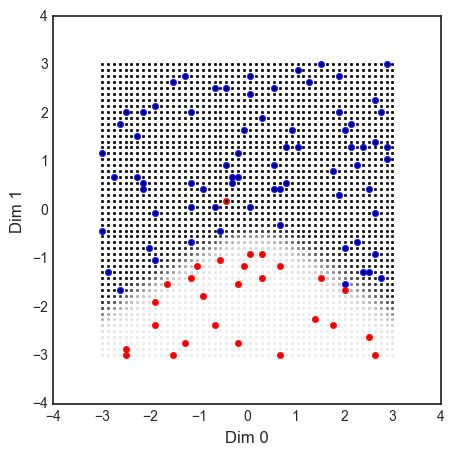

In [42]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()

ax.scatter(x_train[(y_train==1)[0], 0], x_train[(y_train==1)[0],  1], color='b')
ax.scatter(x_train[(y_train==0)[0], 0], x_train[(y_train==0)[0],  1], color='r')

ax.set_xlabel('Dim '+str(0))
ax.set_ylabel('Dim '+str(1))

for x1 in range(px1.size):
  for x2 in range(px2.size):
    ax.scatter(px1[x1], px2[x2], s=3, color='k', alpha=posterior_mean[x1, x2])
    
gif = plt.plot

### Define Vanilla Logistic Regression

In [43]:
W = Normal(mu=tf.zeros(D), sigma=tf.ones(D))
b = Normal(mu=tf.zeros(1), sigma=tf.ones(1))

x = tf.convert_to_tensor(x_train, dtype=tf.float32)
y = Bernoulli(logits=(ed.dot(x, W) + b))

In [44]:
qW = Normal(mu=tf.Variable(tf.random_normal([D])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(mu=tf.Variable(tf.random_normal([1])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [45]:
data = {y: y_train}
inference = ed.MFVI({W: qW, b: qb}, data)

In [46]:
sess = ed.get_session()
init = tf.initialize_all_variables()
inference.run(n_iter=1000, n_print=100, n_samples=5)

Iteration    1 [  0%]: Loss = 64.174
Iteration  100 [ 10%]: Loss = 29.199
Iteration  200 [ 20%]: Loss = 29.967
Iteration  300 [ 30%]: Loss = 28.694
Iteration  400 [ 40%]: Loss = 31.485
Iteration  500 [ 50%]: Loss = 29.314
Iteration  600 [ 60%]: Loss = 28.665
Iteration  700 [ 70%]: Loss = 29.391
Iteration  800 [ 80%]: Loss = 29.584
Iteration  900 [ 90%]: Loss = 28.498
Iteration 1000 [100%]: Loss = 29.621


In [47]:
y_post = ed.copy(y, {W_0: qW_0.mean(), b_0: qb_0.mean(),       
                     W_1: qW_1.mean(), b_1: qb_1.mean(),
                     W_2: qW_2.mean(), b_1: qb_2.mean()})

In [48]:
# Plugin estimate of posterior predictive evaluated on training data
y_post.mean().eval()

array([ 0.54161942,  0.57740772,  0.55799675,  0.64430988,  0.43412241,
        0.20413727,  0.69202965,  0.56451452,  0.78281516,  0.45349759,
        0.27292174,  0.82410711,  0.40378383,  0.61664015,  0.23335001,
        0.35731554,  0.1958136 ,  0.45174626,  0.48431015,  0.18864517,
        0.56125826,  0.66188788,  0.81731421,  0.12656686,  0.74885374,
        0.72456765,  0.58370638,  0.35153505,  0.58206087,  0.2390745 ,
        0.83972251,  0.64558369,  0.40704662,  0.44527382,  0.41801628,
        0.76922607,  0.22283933,  0.17876923,  0.5917595 ,  0.20209269,
        0.57388055,  0.14917099,  0.19987068,  0.83616924,  0.32508406,
        0.39419124,  0.28883576,  0.5255273 ,  0.43404835,  0.64417177,
        0.85250288,  0.14100248,  0.201947  ,  0.43571162,  0.54658103,
        0.55313236,  0.29264981,  0.55130988,  0.25021753,  0.40690121,
        0.75110936,  0.69887751,  0.29693323,  0.67376399,  0.16843712,
        0.58198762,  0.64403367,  0.48446062,  0.52207595,  0.25

In [49]:
print('Log likelihood on training data:')
print(ed.evaluate('log_lik', data={x: x_train, y_post: y_train}))
print()
print('Binary accuracy on training data:')
print(ed.evaluate('binary_accuracy', data={x: x_train, y_post: y_train}))

Log likelihood on training data:
-1.01378

Binary accuracy on training data:
0.7


In [53]:
posterior_mean = tf.sigmoid(ed.dot(x_viz, qW.mean())+ qb.mean()).eval()
posterior_mean = posterior_mean.reshape(px1.size, px2.size)

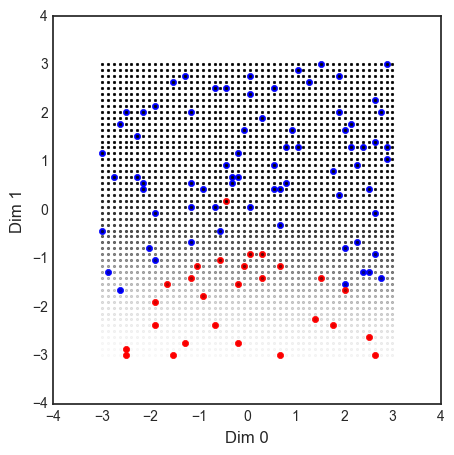

In [54]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()

ax.scatter(x_train[(y_train==1)[0], 0], x_train[(y_train==1)[0],  1], color='b')
ax.scatter(x_train[(y_train==0)[0], 0], x_train[(y_train==0)[0],  1], color='r')

ax.set_xlabel('Dim '+str(0))
ax.set_ylabel('Dim '+str(1))

for x1 in range(px1.size):
  for x2 in range(px2.size):
    ax.scatter(px1[x1], px2[x2], s=3, color='k', alpha=posterior_mean[x1, x2])
    
gif = plt.plot

### Load testing dataset

In [23]:
df = np.loadtxt('crabs_test.txt', dtype='float32', delimiter=',')
x_test = df[:, 1:]

x_test = x_test - x_col_offset
y_test = df[:, 0].astype(int)
y_test[y_test==-1] = 0
y_test = np.atleast_2d(y_test)

ValueError: operands could not be broadcast together with shapes (100,5) (2,) 

In [13]:
# Plugin estimate of posterior predictive evaluated on testing data
y_post = ed.copy(y, {W_0: qW_0.mean(), b_0: qb_0.mean(),       
                     W_1: qW_1.mean(), b_1: qb_1.mean(),
                     x: x_test})
y_post.mean().eval()

array([ 0.87313414,  0.87313414,  0.87313414,  0.87313414,  0.19772668,
        0.87313414,  0.87313414,  0.87313414,  0.87313414,  0.87313414,
        0.87313414,  0.87313414,  0.87313414,  0.87313414,  0.87313414,
        0.87313414,  0.87313414,  0.87313414,  0.87313414,  0.87313414,
        0.87313414,  0.87319708,  0.87313414,  0.87313414,  0.87313414,
        0.87313414,  0.87313414,  0.87313414,  0.87313414,  0.87313414,
        0.87313414,  0.87313414,  0.87313414,  0.87313414,  0.87313414,
        0.87313414,  0.87313414,  0.87313414,  0.87313414,  0.8752957 ,
        0.87313414,  0.87313414,  0.87313414,  0.02003812,  0.87313414,
        0.87313414,  0.87313414,  0.87313414,  0.87313414,  0.87313414,
        0.87313414,  0.87313414,  0.87313414,  0.87313414,  0.87313414,
        0.87313414,  0.87313414,  0.87313414,  0.87313414,  0.02003813,
        0.02003813,  0.02003813,  0.02003813,  0.02003813,  0.02003813,
        0.02003813,  0.02003813,  0.02003813,  0.84024853,  0.19

In [13]:
print('Log likelihood on testing data:')
print(ed.evaluate('log_lik', data={x: x_test, y_post: y_test}))
print()
print('Binary accuracy on testing data:')
print(ed.evaluate('binary_accuracy', data={x: x_test, y_post: y_test}))

Log likelihood on testing data:
-0.139373

Binary accuracy on testing data:
0.95


### Visualize posterior mean probability

In [14]:
print(np.min(x_train, axis=0))
print(np.max(x_train, axis=0))

[ -1.97061443e+00  -1.59634805e+00  -1.00651848e+00  -8.89494514e+00
  -2.97415695e+01  -1.31511211e+00  -1.68926990e+00  -2.31853962e-01
  -1.18089926e+00  -3.77808976e+00  -4.77449566e-01  -1.34168434e+00
  -4.68893250e+02]
[  1.82938576e+00   3.46365213e+00   8.63481522e-01   1.05050545e+01
   6.22584305e+01   1.58488798e+00   3.05072999e+00   2.98146069e-01
   1.98910069e+00   7.94191027e+00   7.52550483e-01   1.38831568e+00
   9.33106750e+02]


In [52]:
lo_limits = np.min(x_train, axis=0)
hi_limits = np.max(x_train, axis=0)

num = 20
inputs = np.zeros([num, D], dtype=np.float32)
for d in range(D):
  inputs[:,d] = np.linspace(lo_limits[d], hi_limits[d], num=num, dtype=np.float32)
x_viz = tf.constant(inputs)

AttributeError: 'Tensor' object has no attribute 'shape'

In [100]:
xeval = np.loadtxt('xeval.csv', dtype='float32', delimiter=',')
xeval = xeval
x_viz = tf.constant(xeval)

In [101]:
px1 = np.loadtxt('px1.csv', dtype='float32', delimiter=',')
px2 = np.loadtxt('px2.csv', dtype='float32', delimiter=',')

In [56]:
px1 = np.linspace(-4, 4, 50)
px2 = np.linspace(-4, 4, 50)

px1_m, px2_m = np.mgrid[-4:4:50j, -4:4:50j]
xeval = np.vstack((px1_m.flatten(), px2_m.flatten())).T
xeval_full = np.ones((xeval.shape[0], D), dtype='float32')
xeval_full[:xeval.shape[0],:xeval.shape[1]] = xeval
x_viz = tf.constant(xeval_full)

In [57]:
# posterior_mean = tf.sigmoid(neural_network(x_viz, qW_0.mean(), qW_1.mean(), qb_0.mean(), qb_1.mean())).eval()
posterior_mean = tf.sigmoid(neural_network(x_viz, qW_0.mean(), qW_1.mean(), qW_2.mean(), 
                                                  qb_0.mean(), qb_1.mean(), qb_2.mean())).eval()

In [59]:
posterior_mean = posterior_mean.reshape(px1.size, px2.size)

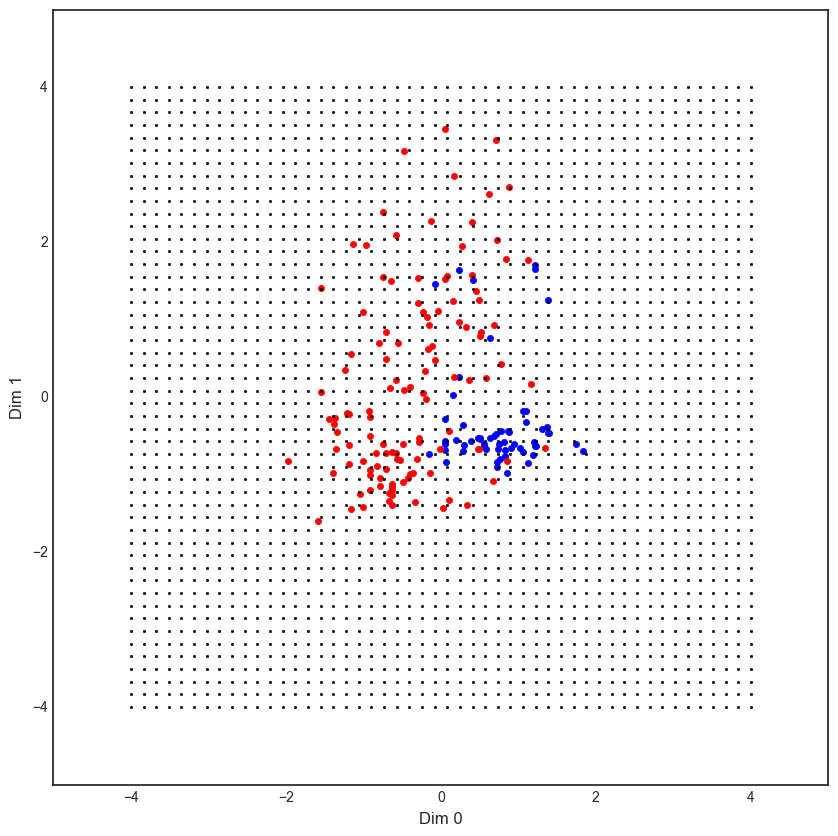

In [60]:
fig = plt.figure(figsize=(10 ,10))
ax = plt.subplot()

ax.scatter(x_train[(y_train==1)[0], 0], x_train[(y_train==1)[0],  1], color='b')
ax.scatter(x_train[(y_train==0)[0], 0], x_train[(y_train==0)[0],  1], color='r')

ax.set_xlabel('Dim '+str(0))
ax.set_ylabel('Dim '+str(1))

for x1 in range(px1.size):
  for x2 in range(px2.size):
    ax.scatter(px1[x1], px2[x2], s=3, color='k', alpha=posterior_mean[x1, x2])
    
gif = plt.plot

### Posterior predictive checks

In [21]:
def T(xs, zs):
  return tf.reduce_max(xs[y_post])

ppc_max = ed.ppc(T, data={x: x_train, y_post: y_train})

T_of_data = ppc_max[1][0]
print(ppc_max)

# xplot = np.linspace(T_of_data-0.2*T_of_data, T_of_data+0.2*T_of_data, 1e2)

# # kernel = gaussian_kde(ppc_max[0])

# fig = plt.figure(figsize=(6,3))
# ax = plt.subplot()

# ax.axvline(T_of_data, ymin=0, ymax=10, label='T_max of data')
# # ax.plot(xplot, kernel(xplot), label='PPD of T_max')

# ax.legend(loc=1)

# gif = plt.plot

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])]


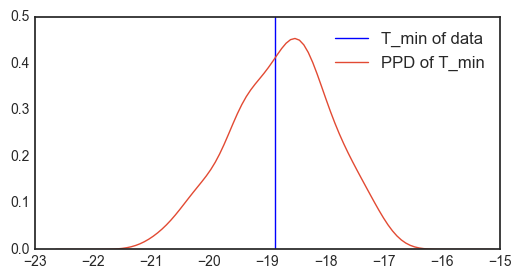

In [40]:
def T(xs, zs):
  return tf.reduce_min(xs[y_post])

ppc_max = ed.ppc(T, data={X: X_train, y_post: y_train})

T_of_data = ppc_max[1][0]

xplot = np.linspace(T_of_data-0.2*T_of_data, T_of_data+0.2*T_of_data, 1e2)

kernel = gaussian_kde(ppc_max[0])

fig = plt.figure(figsize=(6,3))
ax = plt.subplot()

ax.axvline(T_of_data, ymin=0, ymax=10, label='T_min of data')
ax.plot(xplot, kernel(xplot), label='PPD of T_min')

ax.legend(loc=1)

gif = plt.plot

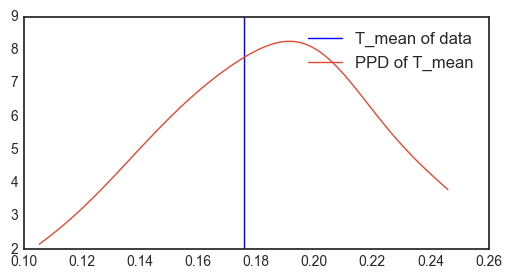

In [41]:
def T(xs, zs):
  return tf.reduce_mean(xs[y_post])

ppc_max = ed.ppc(T, data={X: X_train, y_post: y_train})

T_of_data = ppc_max[1][0]

xplot = np.linspace(T_of_data-0.4*T_of_data, T_of_data+0.4*T_of_data, 1e2)

kernel = gaussian_kde(ppc_max[0])

fig = plt.figure(figsize=(6,3))
ax = plt.subplot()

ax.axvline(T_of_data, ymin=0, ymax=10, label='T_mean of data')
ax.plot(xplot, kernel(xplot), label='PPD of T_mean')

ax.legend(loc=1)

gif = plt.plot

In [25]:
# # Sample functions from variational model to visualize fits.
# rs = np.random.RandomState(0)
# inputs = np.linspace(-5, 5, num=400, dtype=np.float32)
# x_viz = tf.expand_dims(tf.constant(inputs), 1)
# mus = []
# for s in range(25):
#   mus += [tf.sigmoid(neural_network(x_viz, qW_0.sample(), qW_1.sample(),
#                                     qb_0.sample(), qb_1.sample()))]

# mus = tf.pack(mus)

In [26]:
# outputs = mus.eval()

# posterior_mean = tf.sigmoid(neural_network(x_viz, qW_0.mean(), qW_1.mean(), qb_0.mean(), qb_1.mean())).eval()

# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111)
# # ax.set_title("Iteration: 1000 - (CLOSE WINDOW TO TERMINATE)")
# ax.plot(x_train, y_train.T, 'ks', alpha=0.5, label='(x, y)')
# # ax.plot(inputs, np.mean(outputs, axis=0), 'r', lw=2, alpha=0.9, label='posterior mean')
# ax.plot(inputs, posterior_mean.T, 'r', lw=2, alpha=0.9, label='posterior mean')
# ax.plot(inputs, np.mean(outputs, axis=0) - 2*np.std(outputs, axis=0), 'r', lw=1, alpha=0.5)
# ax.plot(inputs, np.mean(outputs, axis=0) + 2*np.std(outputs, axis=0), 'r', lw=1, alpha=0.5)
# # ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
# # ax.set_xlim([-5, 5])
# ax.set_ylim([-0.5, 1.5])
# ax.legend()
# plt.show()

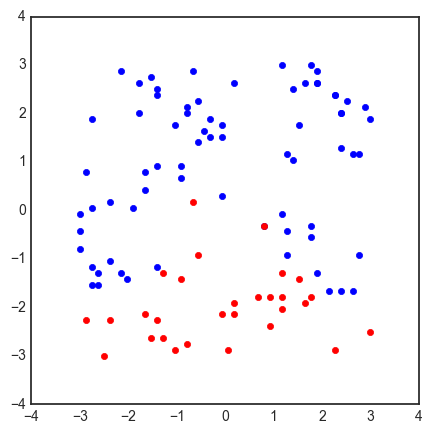